# 6.5~6.7 자전거 대여 수요 예측 경진대회 모델 성능 개선

- 베이스라인 모델과 성능 개선 프로세스 비교
 - 피처 엔지니어링을 본격적으로 수행
 - 모델 훈련 단계에서 하이퍼파라미터 최적화 수행
 - 성능이 만족스럽지 못하면 피처 엔지니어링이나 하이퍼파라미터 최적화를 더 고민해봄
  <div>
    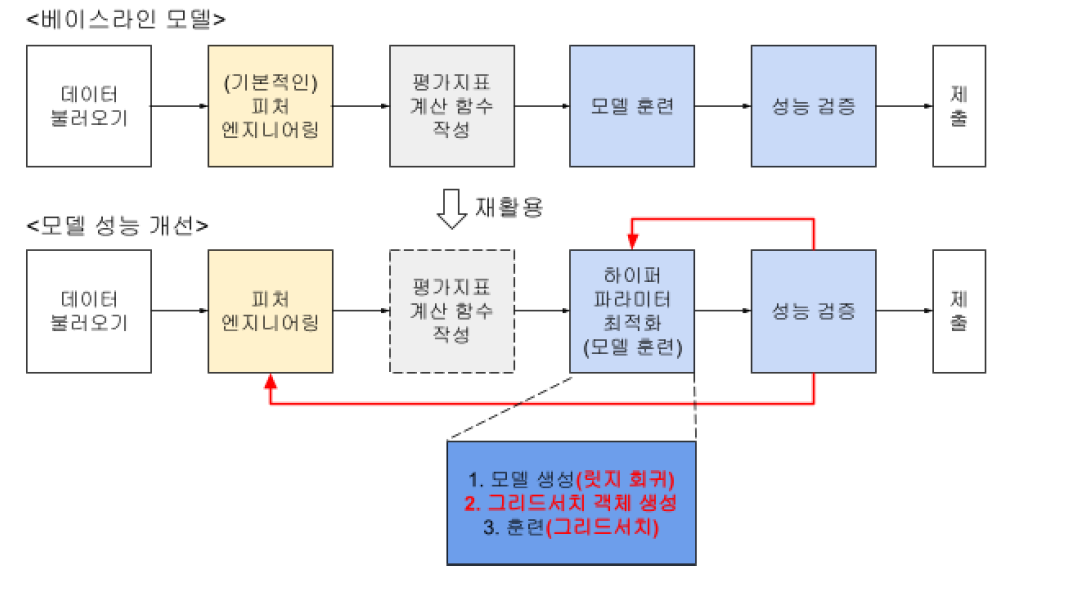
  </div>
 - 이번 장은 튜토리얼이므로 피처 엔지니어링을 추가로 진행하지 않음
 - 그러니 베이스라인용 노트북을 복사한 뒤, ‘데이터 불러오기’ → ‘피처 엔지니어링’ → ‘평가지표 계산 함수 작성’까지 실행해주세요!

In [1]:
import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피처 엔지니어링

### 이상치 제거

In [2]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 변수(피처) 추가

In [4]:
all_data['datetime'] = pd.to_datetime(all_data['datetime']) # datetime 타입으로 바꾸기

all_data['year'] = all_data['datetime'].dt.year         # 연도
all_data['month'] = all_data['datetime'].dt.month       # 월
all_data['hour'] = all_data['datetime'].dt.hour         # 시간
all_data['weekday'] = all_data['datetime'].dt.weekday # 요일 (day_name 요일은 문자열로, weekday는 숫자로 반환)

### 필요 없는 피처 제거

In [5]:
drop_features = ['casual', 'registered', 'datetime', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [6]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

## 평가지표 계산 함수 작성

In [7]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

# 6.5 성능 개선 I : 릿지 회귀 모델
- L2 규제를 적용한 선형 회귀 모델
 - 규제(regularization)란 모델이 훈련 데이터에 과대적합(overfitting)되지 않도록 해주는 방법
 - 훈련 데이터에 과대적합되면 모델이 훈련 데이터에만 너무 잘 들어맞고, 테스트 데이터로는 제대로 예측하지 못함

## L1, L2 Norm
* L1 Norm: 맨해튼 거리(Manhattan Distance)
* L2 Norm: 유클리드 거리(Euclidean Distance)

## L1, L2 Loss
* L1 loss: $L = \sum_{i=1}^{n}|y_i - f(x_i)|$
* L2 loss: $L = \sum_{i=1}^{n}(y_i - f(x_i))^2$

## L1, L2 Regularization
$L1 Cost = \frac{1}{n} \sum_{i=1}^{n} \{ L(y_i, \hat{y_i}) + \frac{\lambda}{2} |\vec{w}| \}$  

$L2 Cost = \frac{1}{n} \sum_{i=1}^{n} \{ L(y_i, \hat{y_i}) + \frac{\lambda}{2} |\vec{w}|^2 \}$ 

$L(y_i, \hat{y_i})$: 기존의 Cost function

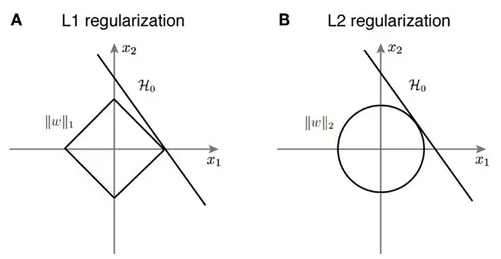!

## 특징
* L1 Cost: $\vec{w}$가 꼭짓점 부분으로 최적화되면 다른 벡터 (feature) 성분이 0이 됨 
  -> Feature Selection이 가능하고, Sparse model에 적합
  
* L2 Cost: $|\vec{w}|^2$를 더하기 때문에 L1에 비해 더 민감함.
  -> Outlier를 더 확실히 죽이는 효과

## 6.5.1 하이퍼 파라미터 최적화(모델 훈련)
#### 그리드서치
- 그리드서치(grid search)는 하이퍼파라미터 최적화 기법 중 하나로, 격자(grid)처럼 촘촘하게 순회하며 최적 하이퍼파라미터 값을 찾는 기법
- 각 하이퍼파라미터를 적용한 모델마다 교차 검증(cross-validation)하며 성능을 측정해 최종적으로 성능이 가장 좋았을 때의 하이퍼파라미터 값을 찾음
- 그리드서치를 이용하지 않으면 수작업으로 하이퍼파라미터 값을 전달해서 성능을 측정 해야 함
  <div>
    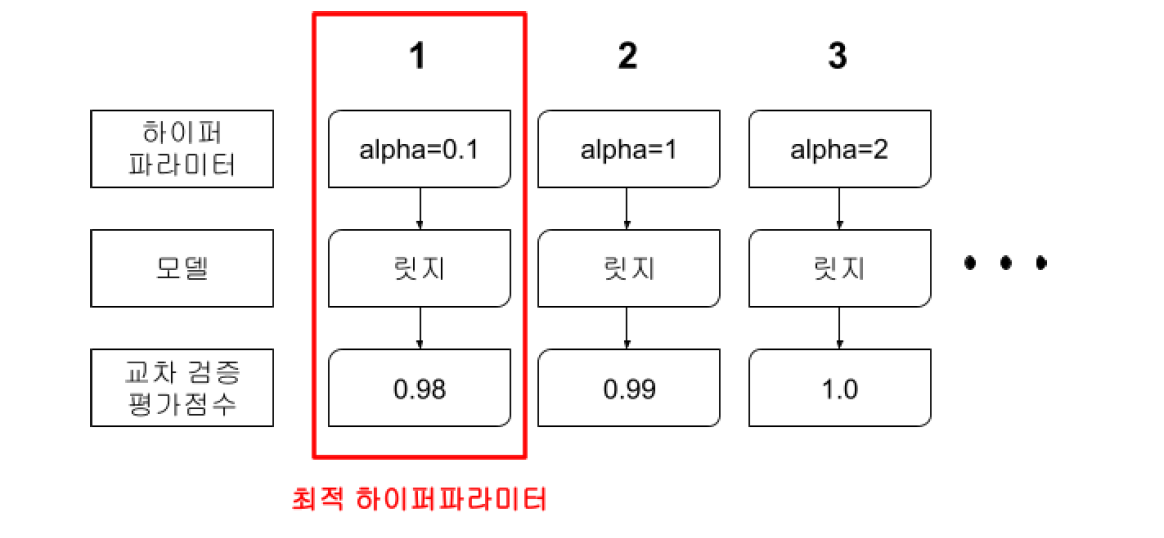
  </div>
- 그리드서치가 추가되면서 하이퍼파라미터 최적화 절차는 다음과 같이 세분화됨
  <div>
    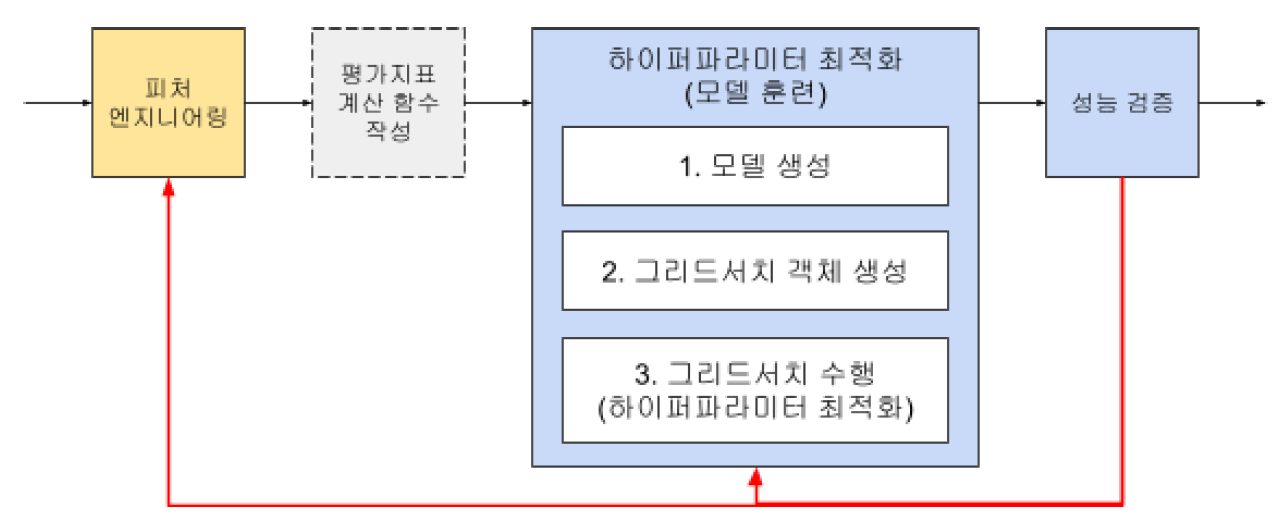
  </div>

### 모델 생성

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

In [ ]:
# value for hyperparameter
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                     param_grid=ridge_params,
                                     scoring=rmsle_scorer,
                                      cv=5)

In [ ]:
log_y = np.log(y)
gridsearch_ridge_model.fit(X_train, log_y) # train(with grid search)

In [ ]:
print(f'최적 하이퍼파라미터: {gridsearch_ridge_model.best_params_}')

In [ ]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

# 평가
print(f'릿지 회귀 RMSLE 값: {rmsle(log_y, preds, True):.4f}')

In [ ]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_test)

# submission['count'] = np.exp(preds) #지수변환
# submission.to_csv('submission.csv', index=False)

# 6.6 성능 개선 II : 라쏘 회귀 모델

## 6.6.1 하이퍼 파라미터 최적화(모델 훈련)
- 전체 흐름은 릿지 회귀 때와 똑같음

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


## 6.6.2 성능 검증
- 최적 예측기를 활용해 성능 검증

In [11]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


- 여전히 성능이 개선되지 않아 이번에도 결과를 제출하지 않음

# 6.7 성능 개선 III : 랜덤 포레스트 회귀 모델

## 6.7.1 하이퍼 파라미터 최적화(모델 훈련)
- 랜덤 포레스트 회귀 모델로 최적 하이퍼파라미터 값 구하기

In [12]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


## 6.7.2 모델 성능 검증
- 최적 예측기로 성능 확인

In [13]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1126


- RMSLE가 1.02이었던 선형 회귀, 릿지, 라쏘에 비해 큰 폭으로 개선됨
- 네 모델 가운데 가장 우수한 모델은 랜덤 포레스트 회귀

## 6.7.3 예측 및 결과 제출

In [15]:
# 예측
randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False) # 예측 결과를 csv 파일로 저장

In [17]:
submission

,datetime,count
0,2011-01-20 00:00:00,12.127016
1,2011-01-20 01:00:00,4.987765
2,2011-01-20 02:00:00,3.149561
3,2011-01-20 03:00:00,3.457217
4,2011-01-20 04:00:00,2.657465
...,...,...
6488,2012-12-31 19:00:00,211.372081
6489,2012-12-31 20:00:00,169.206299
6490,2012-12-31 21:00:00,98.309605
6491,2012-12-31 22:00:00,100.356196


- 193등 (상위 6.0%)

Text(0.5, 1.0, 'Predicted Test Data Distribution')

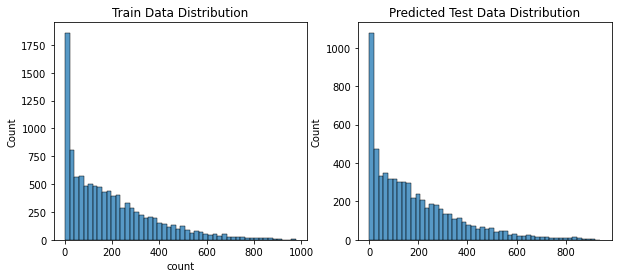

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title("Train Data Distribution")
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title("Predicted Test Data Distribution")